In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("First ML Model") \
    .getOrCreate()


In [2]:
data = spark.read.csv('diabetes.csv', header=True, inferSchema=True)


In [3]:
data.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [4]:
data.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [5]:
data.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [14]:
data

DataFrame[Pregnancies: int, Glucose: int, BloodPressure: int, SkinThickness: int, Insulin: int, BMI: double, DiabetesPedigreeFunction: double, Age: int, Outcome: int]

In [7]:
data.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [8]:
from pyspark.sql.functions import col, isnan, when, count

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()


+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



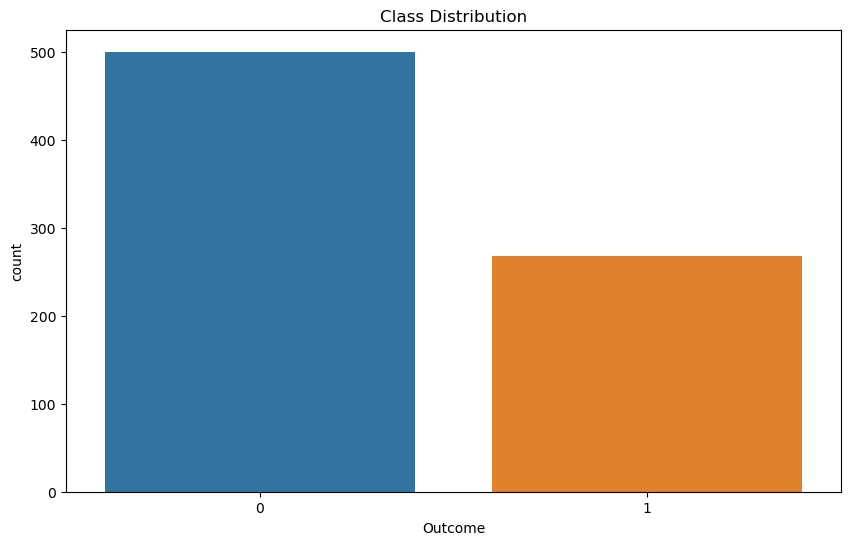

In [15]:
# Count occurrences of each class in the target column "Outcome"
class_counts = data.groupBy("Outcome").count()
class_counts.show()

# Convert to Pandas DataFrame for easier manipulation and visualization
class_counts_pd = class_counts.toPandas()

# Plot class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Outcome', y='count', data=class_counts_pd)
plt.title('Class Distribution')
plt.show()


In [11]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F

numeric_cols = [col[0] for col in data.dtypes if col[1] != 'string']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
data_vector = assembler.transform(data).select("features")

correlation_matrix = Correlation.corr(data_vector, "features").head()[0]
print(correlation_matrix)


DenseMatrix([[ 1.        ,  0.12945867,  0.14128198, -0.08167177, -0.07353461,
               0.01768309, -0.03352267,  0.54434123,  0.22189815],
             [ 0.12945867,  1.        ,  0.15258959,  0.05732789,  0.33135711,
               0.22107107,  0.1373373 ,  0.26351432,  0.4665814 ],
             [ 0.14128198,  0.15258959,  1.        ,  0.20737054,  0.08893338,
               0.28180529,  0.04126495,  0.23952795,  0.06506836],
             [-0.08167177,  0.05732789,  0.20737054,  1.        ,  0.43678257,
               0.3925732 ,  0.18392757, -0.11397026,  0.07475223],
             [-0.07353461,  0.33135711,  0.08893338,  0.43678257,  1.        ,
               0.19785906,  0.18507093, -0.04216295,  0.13054795],
             [ 0.01768309,  0.22107107,  0.28180529,  0.3925732 ,  0.19785906,
               1.        ,  0.14064695,  0.03624187,  0.29269466],
             [-0.03352267,  0.1373373 ,  0.04126495,  0.18392757,  0.18507093,
               0.14064695,  1.        ,  0.03

In [12]:
pandas_df = data.toPandas()


C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


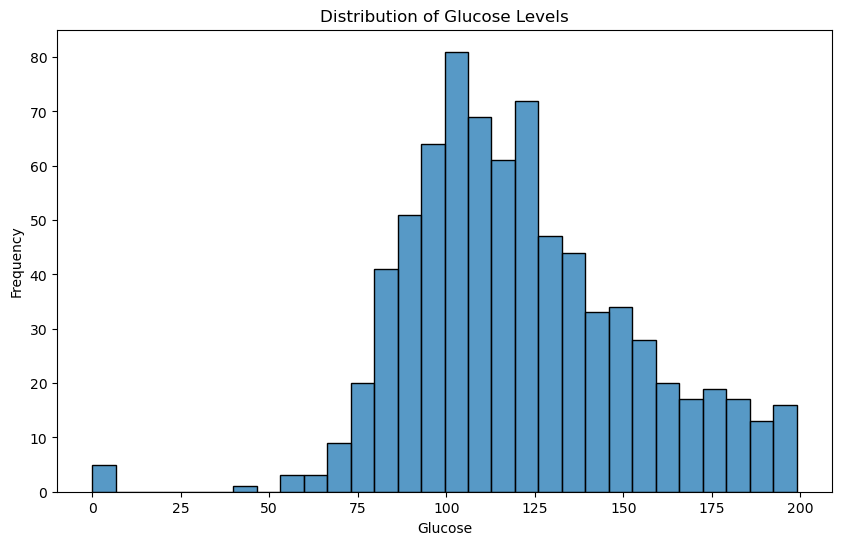

C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


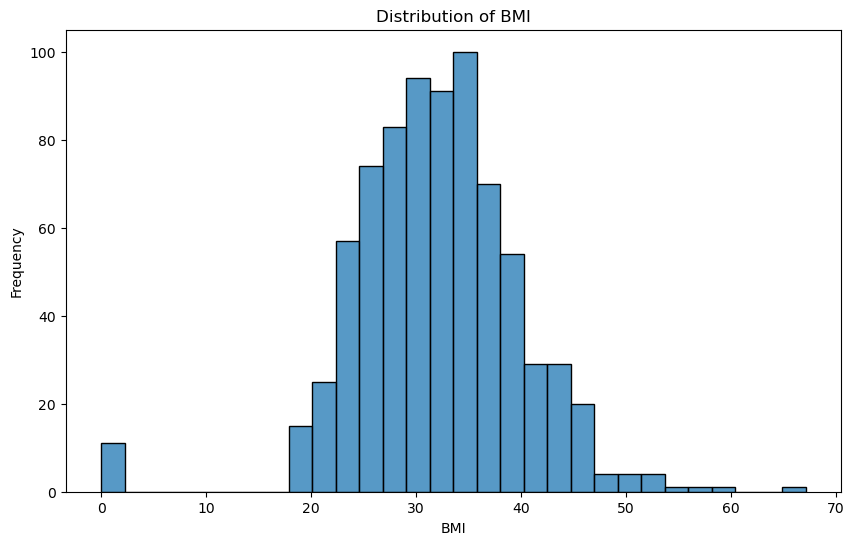

In [16]:
# Example: Plotting a histogram of the 'Glucose' column
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['Glucose'], bins=30)
plt.title('Distribution of Glucose Levels')
plt.xlabel('Glucose')
plt.ylabel('Frequency')
plt.show()

# Example: Plotting a histogram of the 'BMI' column
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['BMI'], bins=30)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()


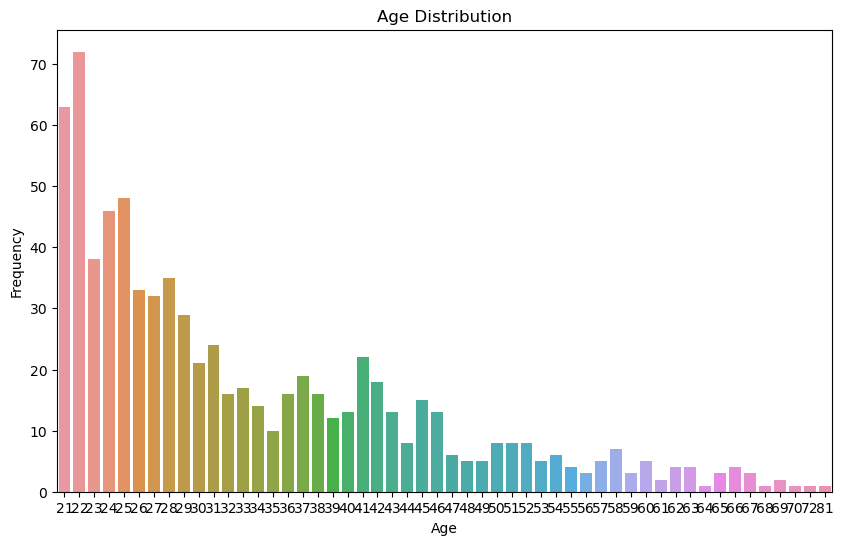

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age', data=pandas_df)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [18]:
# Assuming the target variable is named "Outcome"
independent_cols = [col for col in data.columns if col != "Outcome"]

# Select independent variables
independent_data = data.select(independent_cols)


In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=independent_cols, outputCol="features")
assembled_data = assembler.transform(independent_data)

# Compute the correlation matrix
correlation_matrix = Correlation.corr(assembled_data, "features").head()[0]


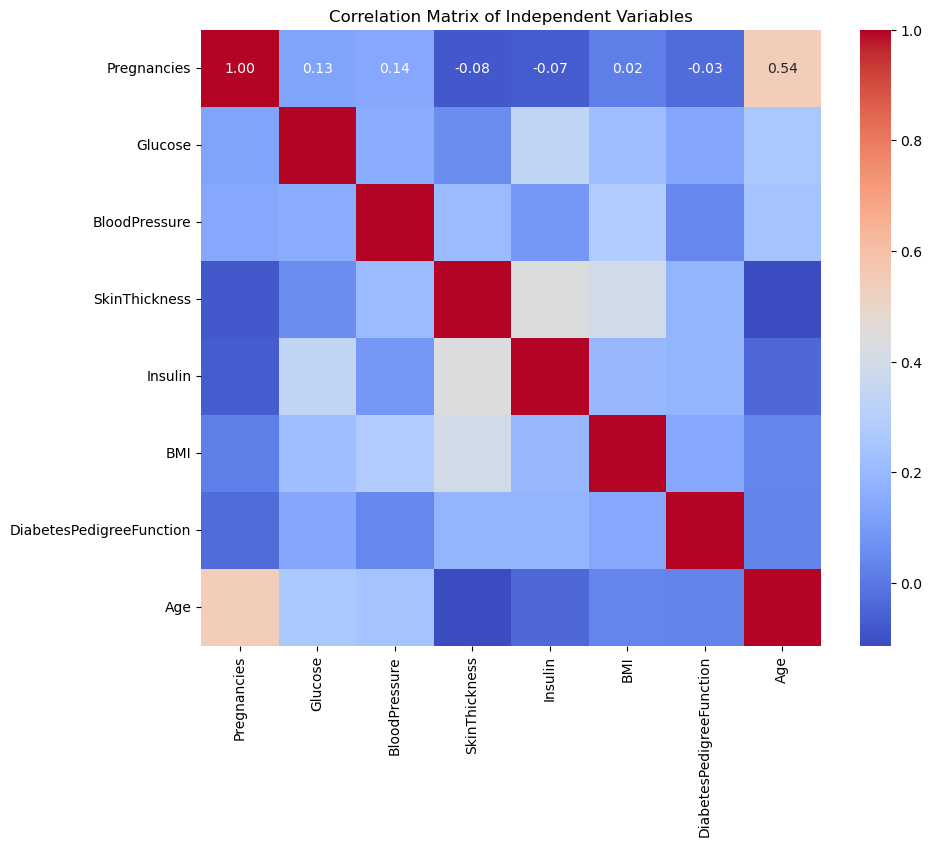

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert correlation matrix to Pandas DataFrame for visualization
corr_df = pd.DataFrame(correlation_matrix.toArray(), columns=independent_cols, index=independent_cols)

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Independent Variables')
plt.show()


In [21]:
from pyspark.sql.functions import col, isnan, when, count

# Count missing values in each column
missing_counts = data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])
missing_counts.show()


+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [22]:
# Drop rows with any missing values
data_no_missing = data.dropna()


In [23]:
from pyspark.ml.feature import VectorAssembler


In [26]:
from pyspark.ml.feature import VectorAssembler

# Define the input feature columns
input_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Name of the output vector column
output_col = 'features'

# Create the VectorAssembler object
assembler = VectorAssembler(inputCols=input_cols, outputCol=output_col)

# Apply the VectorAssembler to transform the DataFrame
data_assembled = assembler.transform(data)


In [36]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("YourApp") \
    .getOrCreate()

# Assuming you already have your DataFrame 'data' and 'data_assembled'

# Set seed for reproducibility
seed = 42

# Split the data into training and testing sets
train_data, test_data = data_assembled.randomSplit([0.8, 0.2], seed=42)

# Display the number of rows in each set
print("Train set count:", train_data.count())
print("Test set count:", test_data.count())

# Define the model
rf = RandomForestClassifier(labelCol="Outcome", featuresCol="features", seed=seed)

# Train the model
rf_model = rf.fit(train_data)

# Make predictions on test data
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Outcome")
auc = evaluator.evaluate(predictions)

print("Random Forest AUC:", auc)


Train set count: 645
Test set count: 123
Random Forest AUC: 0.8377906976744187


In [38]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the Random Forest Classifier model
rf = RandomForestClassifier(labelCol="Outcome", featuresCol="features", seed=seed)

# Train the Random Forest Classifier model
rf_model = rf.fit(train_data)

# Make predictions on test data
rf_predictions = rf_model.transform(test_data)

# Evaluate the Random Forest Classifier model
evaluator = BinaryClassificationEvaluator(labelCol="Outcome")
rf_auc = evaluator.evaluate(rf_predictions)

print("Random Forest AUC:", rf_auc)


Random Forest AUC: 0.8377906976744187


In [39]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the Decision Tree Classifier model
dt = DecisionTreeClassifier(labelCol="Outcome", featuresCol="features", seed=seed)

# Train the Decision Tree Classifier model
dt_model = dt.fit(train_data)

# Make predictions on test data
dt_predictions = dt_model.transform(test_data)

# Evaluate the Decision Tree Classifier model
evaluator = BinaryClassificationEvaluator(labelCol="Outcome")
dt_auc = evaluator.evaluate(dt_predictions)

print("Decision Tree AUC:", dt_auc)


Decision Tree AUC: 0.747093023255814


In [41]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the Gradient-Boosted Tree Classifier model
gbt = GBTClassifier(labelCol="Outcome", featuresCol="features", maxIter=10, seed=seed)

# Train the Gradient-Boosted Tree Classifier model
gbt_model = gbt.fit(train_data)

# Make predictions on test data
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the Gradient-Boosted Tree Classifier model
evaluator = BinaryClassificationEvaluator(labelCol="Outcome")
gbt_auc = evaluator.evaluate(gbt_predictions)

print("Gradient-Boosted Tree AUC:", gbt_auc)


Gradient-Boosted Tree AUC: 0.7991279069767443


In [42]:
print("Model Performance:")
print("Random Forest AUC:", rf_auc)
print("Gradient-Boosted Tree AUC:", gbt_auc)


Model Performance:
Random Forest AUC: 0.8377906976744187
Gradient-Boosted Tree AUC: 0.7991279069767443
